In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-car-sales-2010-2024/IEA-EV-dataEV salesHistoricalCars.csv


# =======================
# 📦 1: Import Libraries
# =======================

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# =======================
# 📂 2: Load Dataset
# =======================

In [3]:
file_path = '/kaggle/input/electric-car-sales-2010-2024/IEA-EV-dataEV salesHistoricalCars.csv'
df = pd.read_csv(file_path)

print("✅ Data Loaded Successfully")
print("Shape:", df.shape)
print(df.head())

✅ Data Loaded Successfully
Shape: (3798, 8)
      region    category       parameter  mode powertrain  year      unit  \
0  Australia  Historical        EV sales  Cars        BEV  2011  Vehicles   
1  Australia  Historical  EV stock share  Cars         EV  2011   percent   
2  Australia  Historical  EV sales share  Cars         EV  2011   percent   
3  Australia  Historical        EV stock  Cars        BEV  2011  Vehicles   
4  Australia  Historical        EV stock  Cars        BEV  2012  Vehicles   

       value  
0   49.00000  
1    0.00039  
2    0.00650  
3   49.00000  
4  220.00000  


# =======================
# 🧹 3: Data Cleaning
# =======================

In [4]:
df = df.dropna()
df['year'] = df['year'].astype(int)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df.dropna()

# =======================
# 🔠 4: Encoding Categorical Columns
# =======================

In [5]:
cat_cols = ['region', 'category', 'parameter', 'powertrain']
le_dict = {}

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le

print("✅ Label Encoding Complete")

✅ Label Encoding Complete


# =======================
# ⚙️ 5: Feature Selection
# =======================

In [6]:
X = df.drop(columns=['value'])
y = df['value']

# =======================
# 🧪 6: Train-Test Split
# =======================

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =======================
# 📏 7: Feature Scaling
# =======================

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Step 1: Encode all non-numeric columns
non_numeric = df.select_dtypes(exclude=[np.number]).columns
for col in non_numeric:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    print(f"Encoded column: {col}")

# Step 2: Recreate feature and target sets AFTER encoding
X = df.drop(columns=['value'])
y = df['value']

# Step 3: Split again (important — otherwise X_train/X_test refer to old unencoded data)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Check all columns are numeric
non_numeric = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print("⚠️ Non-numeric columns detected:", list(non_numeric))
else:
    print("✅ All features are numeric and ready for scaling")

# Step 5: Check for missing values
missing = X.isnull().sum()
if missing.sum() > 0:
    print("⚠️ Missing values detected:")
    print(missing[missing > 0])
else:
    print("✅ No missing values in X")

# Step 6: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Feature scaling complete.")


Encoded column: mode
Encoded column: unit
✅ All features are numeric and ready for scaling
✅ No missing values in X
✅ Feature scaling complete.


# =======================
# 🌲 8: Random Forest Regressor (Tuned)
# =======================

In [9]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
grid.fit(X_train_scaled, y_train)

best_rf = grid.best_estimator_
print("✅ Best RF Parameters:", grid.best_params_)

✅ Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


# =======================
# 📈 9: Evaluate Model
# =======================

In [10]:
y_pred = best_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 Random Forest Results:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


📊 Random Forest Results:
R² Score: 0.4290
RMSE: 286617.38
MAE: 55176.92


# =======================
# 🔥 10: Gradient Boosting Regressor (Optional Comparison)
# =======================

In [11]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"\n📊 Gradient Boosting Results:")
print(f"R² Score: {r2_gb:.4f}")
print(f"RMSE: {rmse_gb:.2f}")


📊 Gradient Boosting Results:
R² Score: 0.2048
RMSE: 338239.39


# =======================
# 📉 11: Visualization
# =======================

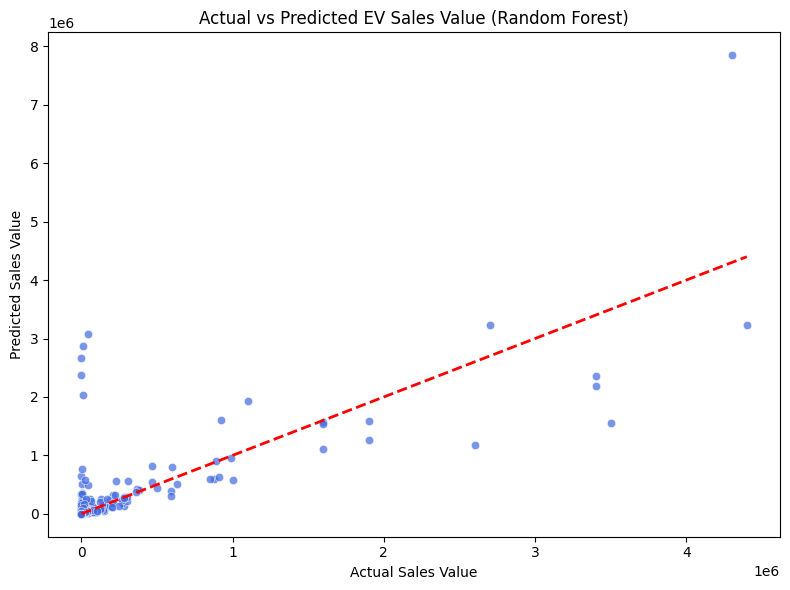

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted EV Sales Value (Random Forest)')
plt.xlabel('Actual Sales Value')
plt.ylabel('Predicted Sales Value')
plt.tight_layout()
plt.show()

# =======================
# ⭐ 12: Feature Importance
# =======================

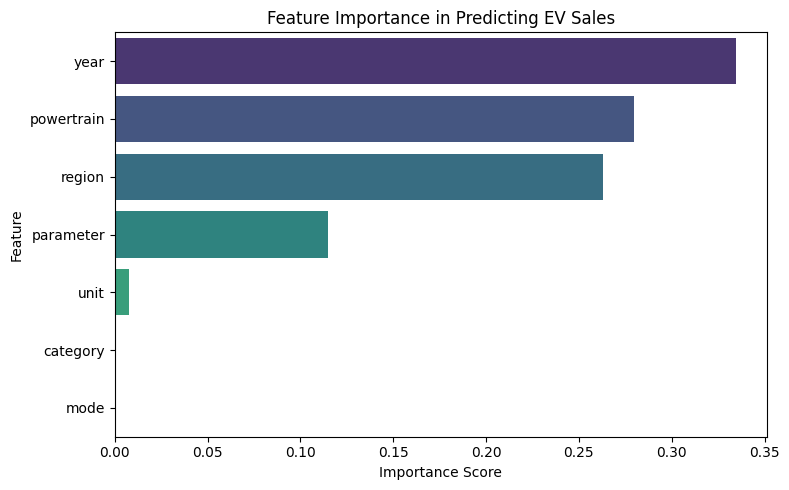

In [13]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features, y=top_features.index, palette='viridis')
plt.title('Feature Importance in Predicting EV Sales')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()